In [4]:
import numpy as np
import pandas as pd
import misc
import matplotlib.pyplot as plt
from misc import get_attr
import time
pd.set_option('mode.chained_assignment', None)
from framework import tester, strategy



In [5]:

spy_df = pd.read_csv('stock_price_data/SPY.csv')
spy_df = misc.clean_df(spy_df)
spy_df

,date,open,high,low,close,adjclose,volume,ticker
0,1993-01-29,43.968750,43.968750,43.750000,43.937500,25.218206,1003200,SPY
1,1993-02-01,43.968750,44.250000,43.968750,44.250000,25.397572,480500,SPY
2,1993-02-02,44.218750,44.375000,44.125000,44.343750,25.451397,201300,SPY
3,1993-02-03,44.406250,44.843750,44.375000,44.812500,25.720430,529400,SPY
4,1993-02-04,44.968750,45.093750,44.468750,45.000000,25.828049,531500,SPY
...,...,...,...,...,...,...,...,...
7581,2023-03-09,399.739990,401.480011,390.529999,391.559998,391.559998,111945300,SPY
7582,2023-03-10,390.989990,393.160004,384.320007,385.910004,385.910004,189105300,SPY
7583,2023-03-13,381.809998,390.390015,380.649994,385.359985,385.359985,157790000,SPY
7584,2023-03-14,390.500000,393.450012,387.049988,391.730011,391.730011,149752400,SPY


{'Total Return': 10.719050239730775}


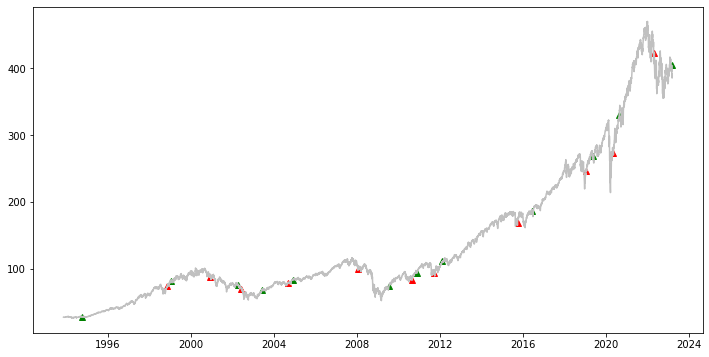

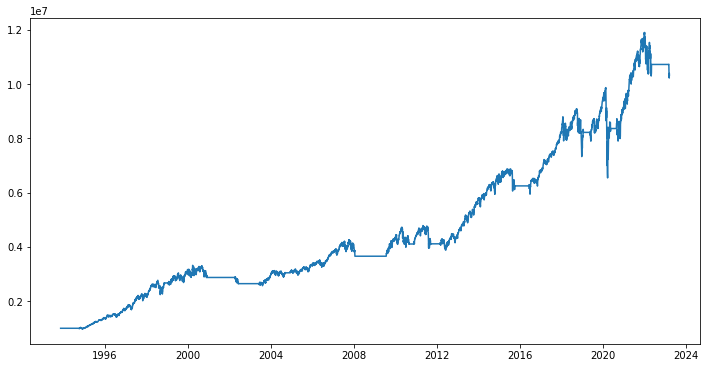

In [6]:
def ma_crossover(input_arr, trader_state, **kwargs):
    '''
    input_arr = ADJC, S, S+1
    trader_state = cash, position, position_value, portfolio_value, margin
    '''
    buy_threshold = get_attr(kwargs, 'buy_threshold', 0)
    sell_threshold = get_attr(kwargs, 'sell_threshold', 0)
    cash, position, _, _, _ = trader_state
    adjclose, signal, signal_1 = input_arr

    limit_order = np.zeros(2)
    if  signal > buy_threshold and signal_1 < buy_threshold:
        limit_order[0] = adjclose
        limit_order[1] = cash // adjclose
    elif signal < sell_threshold and signal_1 > sell_threshold:
        limit_order[0] = adjclose
        limit_order[1] = -position

    return limit_order

def ma_signal(df, **kwargs):
    
    short_period = get_attr(kwargs, 'short_period', 10)
    long_period = get_attr(kwargs, 'long_period', 20)

    df['signal'] = df['adjclose'].rolling(short_period).mean() - df['adjclose'].rolling(long_period).mean()
    df['signal+1'] = df['signal'].shift(1)
    df = df.dropna()

    return df



df = spy_df.copy()
# df = df.iloc[-500:]
ma_strategy = strategy(ma_signal, ma_crossover)
test = tester(ma_strategy)
test.generate_signal(data_df=df, **{'short_period': 100, 'long_period': 200})
test.run_strategy(initial_capital=1e6, **{'buy_threshold': 0, 'sell_threshold': 0, 'strategy_input_features': ['adjclose', 'signal', 'signal+1']})
test.evaluate_strategy()
test.plot_results()

